In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import analysis.shapley_additive_analysis as shapley


# reload(data_loading)
# reload(experiment)
# reload(rnn)
# reload(umap)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train MDM2 vs. 12ca5 Model



In [20]:
import pdb
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "12ca5"
X, mdm2_y, mdm2_y_raw, peptides, FEATURE_LIST = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)

(
    X_train,
    X_test,
    mdm2_y_train,
    mdm2_y_test,
    mdm2_y_raw_train,
    mdm2_y_raw_test,
    peptides_train,
    peptides_test,
) = train_test_split(
    X,
    mdm2_y,
    mdm2_y_raw,
    peptides,
    test_size=0.2,
    shuffle=True,
    random_state=5,
)
# 12ca5 shares the same p-values just inverted log fold change
# so we can get away with using the same dataset and just
# inverting the y value
# TODO(Yitong): We want to put this away in some function
ca5_y_train = np.copy(mdm2_y_train)
ca5_y_train[:,1] = ca5_y_train[:,1] ==0

ca5_y_test= np.copy(mdm2_y_test)
ca5_y_test[:,1] = ca5_y_test[:,1] ==0

ca5_y_raw_train = np.copy(mdm2_y_raw_train)
ca5_y_raw_train[:,1] = -ca5_y_raw_train[:,1]

ca5_y_raw_test = np.copy(mdm2_y_raw_test)
ca5_y_raw_test[:,1] = -ca5_y_raw_test[:,1]

mdm2_model = experiment.BinaryClassificationExperiment().train(
    X_train,
    mdm2_y_train,
    rnn.Joint_BinaryClassificationRNN_gelu,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # After initial training we are loading a pretrained model from memory
    load_trained_model=True,
    model_save_name='mdm2_bilstm.h5',
)
mdm2_y_pred_raw = mdm2_model(X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5

all_targets = list(zip(X, peptides))


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is -0.6565247891915524


In [5]:
# evaluate accuracy, precision, recall of trianed model
print('MDM2')
evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)

# Can we even get away with just flipping the mdm2 model output?
ca5_y_pred_raw_derived_from_mdm2 = np.copy(mdm2_y_pred_raw)
ca5_y_pred_raw_derived_from_mdm2[:, 1] = 1-ca5_y_pred_raw_derived_from_mdm2[:,1]
ca5_y_pred_derived_from_mdm2 = ca5_y_pred_raw_derived_from_mdm2 > 0.5

print('\n12ca5 Derived from inverted MDM2 Model Output')
# evaluate accuracy, precision, recall of trianed model
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred_derived_from_mdm2)


MDM2
P-VAL
	 accuracy:  0.7204921768190794
	 precision:  0.6878625134264232
	 recall:  0.8921705210365004
	 # neg predictions:  1928
	 # pos predictions:  4655
Log Fold
	 accuracy:  0.8827282394045268
	 precision:  0.8812860676009893
	 recall:  0.9903650176023717
	 # neg predictions:  518
	 # pos predictions:  6065

12ca5 Derived from inverted MDM2 Model Output
P-VAL
	 accuracy:  0.7204921768190794
	 precision:  0.6878625134264232
	 recall:  0.8921705210365004
	 # neg predictions:  1928
	 # pos predictions:  4655
Log Fold
	 accuracy:  0.8827282394045268
	 precision:  0.8996138996138996
	 recall:  0.39291736930860033
	 # neg predictions:  6065
	 # pos predictions:  518


Shows that Inverting the MDM2 model is essentially the same as training a separate 12ca5 model

## Shapely Analysis 

In [49]:
from analysis.shapley_additive_analysis import shapley_analysis, INVESTIGATION_TYPE


def investigate_individual_peptides(peptide_seq):
    print(
        f"{peptide_seq} is in the dataset as {mdm2_y_raw[[idx for idx, x in enumerate(peptides) if x == peptide_seq][0]]}"
    )
    shapley_analysis(
        mdm2_model,
        X,
        [x for x in all_targets if x[1] == peptide_seq],  # Known binder
        investigation_type=INVESTIGATION_TYPE.BY_AMINO_ACID,
        num_background_samples=20,#200,
        num_perturbation_samples=1000, #2000,
        aa_feature_dim=len(FEATURE_LIST),
    )

In [68]:
from analysis.hit_rate_analysis import (
    find_12ca5_motif,
    find_mdm2_motif,
    seq_contains_mdm2_motif,
)

mdm2_motif_peptides = [
    (peptide, find_mdm2_motif(peptide).span())
    for peptide in peptides
    if seq_contains_mdm2_motif(peptide)
]
# TODO: Lift the training wheels!
mdm2_motif_peptides = mdm2_motif_peptides[:10]

# [
#     (x_representation, peptide)
#     for x_representation, peptide in all_targets
#     if peptide == "ACFYNLFCE"
# ]
X[peptides.index('ACFYNLFCE')]

# [for peptide, span in mdm2_motif_peptides]

# shapley_analysis(
#     mdm2_model,
#     X,
#     [x for x in all_targets if x[1] == peptide_seq],  # Known binder
#     investigation_type=INVESTIGATION_TYPE.BY_AMINO_ACID,
#     num_background_samples=20,#200,
#     num_perturbation_samples=1000, #2000,
#     aa_feature_dim=len(FEATURE_LIST),
# )


array([[ 6.17255590e-01,  1.92307690e-01,  6.20000000e-01,
         2.10000000e+00, -5.00000000e-01,  7.00000000e-03,
         8.10000000e+00,  0.00000000e+00,  4.60000000e-02,
         1.18100000e+00,  2.75000000e+01, -1.27000000e+00,
         4.90000000e-01,  1.50000000e+01, -8.00000000e-01,
         1.06400000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.10252388e-01,  7.30769230e-01,  2.90000000e-01,
         1.40000000e+00, -1.00000000e+00, -3.70000000e-02,
         5.50000000e+00,  1.48000000e+00,  1.28000000e-01,
         1.46100000e+00,  4.46000000e+01, -1.09000000e+00,
         2.60000000e-01,  5.00

AFWDWFWCA is in the dataset as [-0.27499377  0.46662757]


625/625 [==============================] - 1s 2ms/step
Expected value:  0.339414841553662 shapely value sum  0.23401229915907598
Model eval:  tf.Tensor([0.57342714], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.5734271407127379


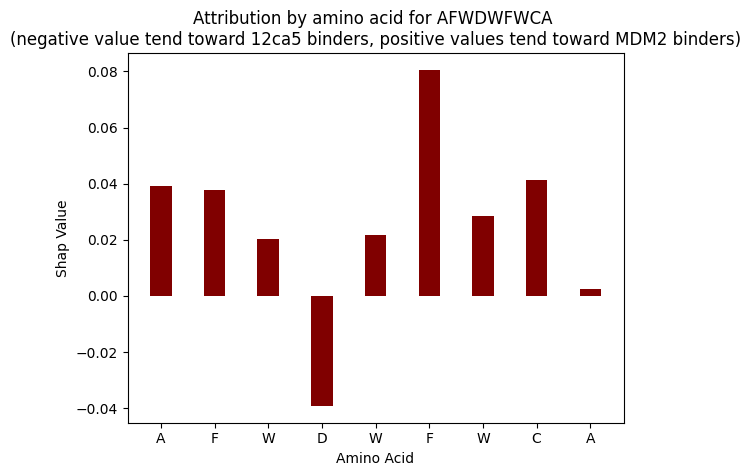

In [50]:
%matplotlib inline
investigate_individual_peptides("AFWDWFWCA")


AFCDYLCNV is in the dataset as [-0.35365716  0.56028434]


625/625 [==============================] - 1s 2ms/step
Expected value:  0.339414841553662 shapely value sum  0.23367505607893693
Model eval:  tf.Tensor([0.5730899], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.5730898976325989


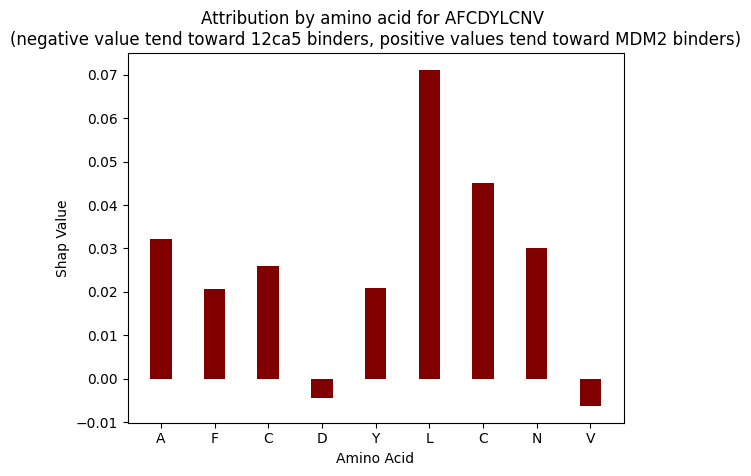

In [51]:
investigate_individual_peptides("AFCDYLCNV")

AFCDWFWSS is in the dataset as [-0.20840332  1.35132244]


625/625 [==============================] - 1s 2ms/step
Expected value:  0.339414841553662 shapely value sum  0.28341066179564234
Model eval:  tf.Tensor([0.6228255], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.6228255033493043


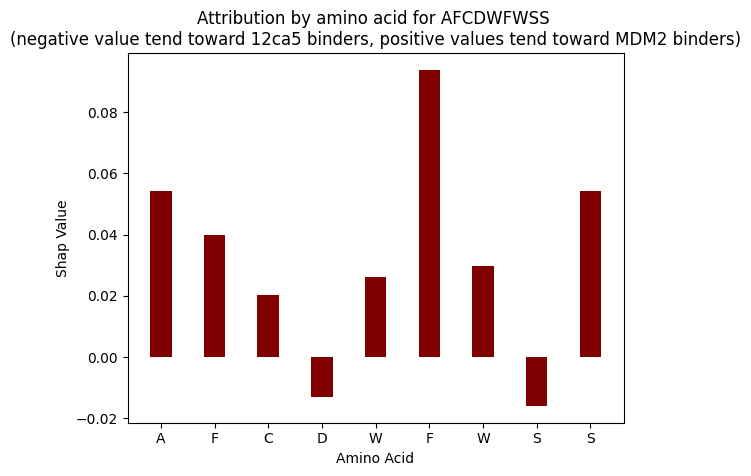

In [52]:
investigate_individual_peptides("AFCDWFWSS")

AFCYLFWCS is in the dataset as [-0.19984816  0.92012466]


625/625 [==============================] - 1s 2ms/step
Expected value:  0.339414841553662 shapely value sum  0.28295713005354634
Model eval:  tf.Tensor([0.622372], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.6223719716072083


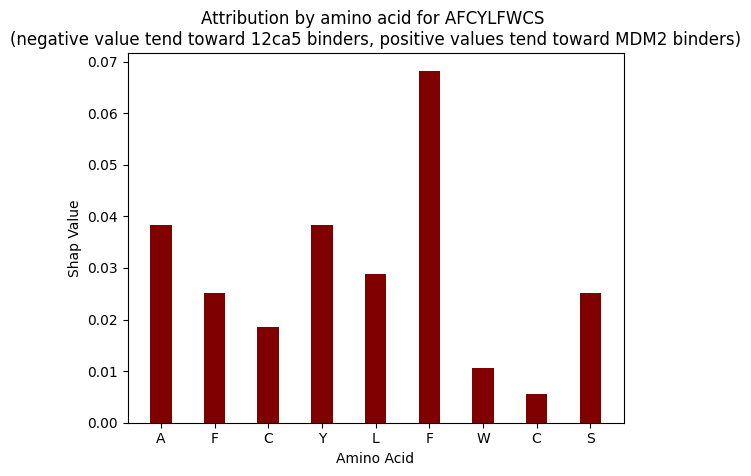

In [53]:
investigate_individual_peptides("AFCYLFWCS")


ACVSFSCWW is in the dataset as [-0.28294845  0.56028434]


625/625 [==============================] - 1s 2ms/step
Expected value:  0.339414841553662 shapely value sum  0.23352252779295665
Model eval:  tf.Tensor([0.5729374], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.5729373693466187


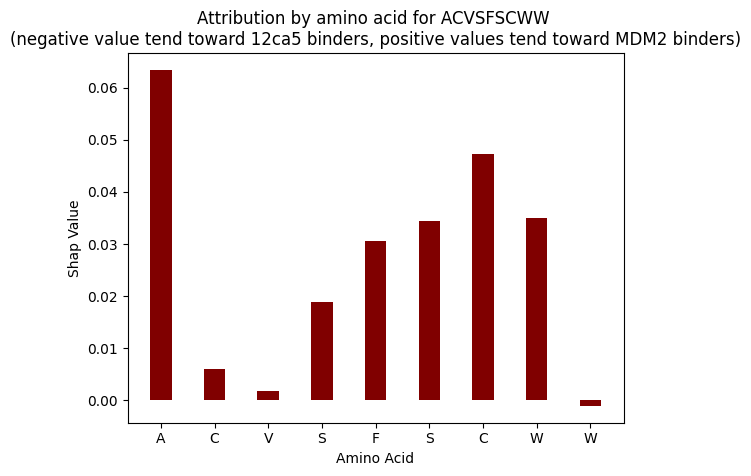

In [54]:
investigate_individual_peptides("ACVSFSCWW")


ACERFACWW is in the dataset as [-0.49148452  0.30492372]


625/625 [==============================] - 1s 2ms/step
Expected value:  0.339414841553662 shapely value sum  0.22451412020018327
Model eval:  tf.Tensor([0.56392896], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.5639289617538452


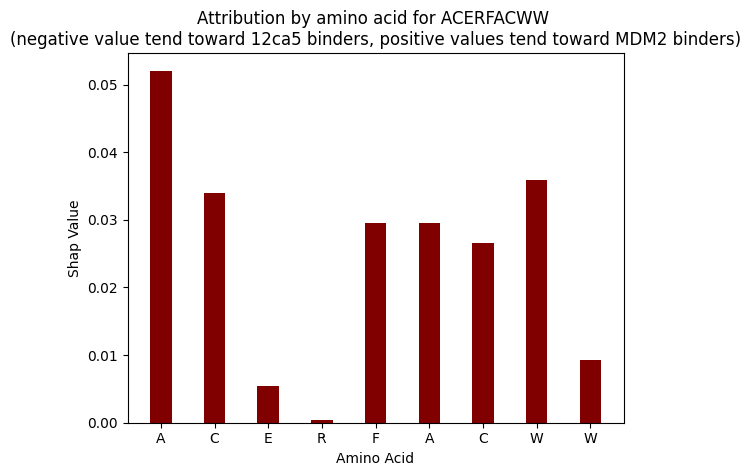

In [55]:
investigate_individual_peptides("ACERFACWW")


In [36]:
investigate_individual_peptides("ACVDYAACR")

ACVDYAACR is in the dataset as [ 1.50397841 -1.72464401]


7/7 [==============================] - 0s 2ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 27s 2ms/step
Expected value:  0.38358128965890503 shapely value sum  -0.37424819880223376
Model eval:  tf.Tensor([0.0093331], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.009333090856671278


AICRGDYAC is in the dataset as [ 4.64522306 -3.43722074]


7/7 [==============================] - 0s 3ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 28s 2ms/step
Expected value:  0.38358128965890503 shapely value sum  -0.38163352279050755
Model eval:  tf.Tensor([0.00194777], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.0019477668683974825


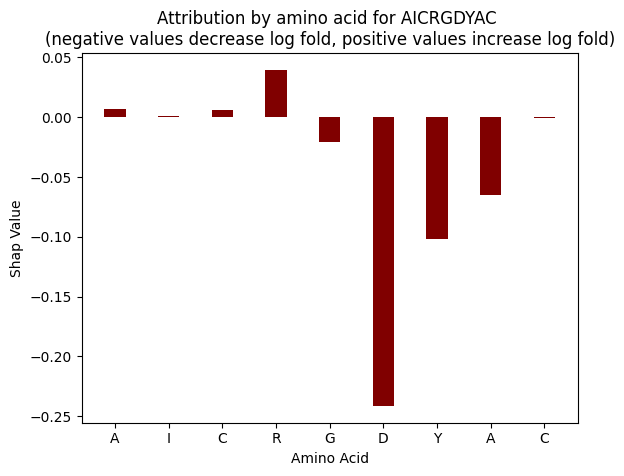

In [34]:
investigate_individual_peptides("AICRGDYAC")

In [35]:
investigate_individual_peptides("DYPDYAE")

DYPDYAE is in the dataset as [ 4.26791951 -3.2639108 ]


7/7 [==============================] - 0s 3ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


12500/12500 [==============================] - 25s 2ms/step
Expected value:  0.38358128965890503 shapely value sum  -0.37951629432907763
Model eval:  tf.Tensor([0.004065], shape=(1,), dtype=float32)
Does this match the sum of shapely values + expected value (\Sum(phi_i) + phi_0)?  0.004064995329827403


In [26]:
from analysis.shapley_additive_analysis import shapley_analysis, INVESTIGATION_TYPE

investigation_target = all_targets[:10]
shapley_analysis(
    mdm2_model,
    X,
    investigation_target, 
    investigation_type=INVESTIGATION_TYPE.BY_FEATURE,
    aa_feature_dim=len(FEATURE_LIST)
)

3125/3125 [==============================] - 6s 2ms/step


KeyboardInterrupt: 